<a href="https://colab.research.google.com/github/tamojit-maiti/machine-learning-from-scratch/blob/main/expectation-maximization-GMM-naive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter Estimation for Gaussian Mixture Models

This notebook is meant to demonstrate the naive method for parameter estimation for Gaussian Mixture Models. 

In [282]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from datetime import datetime

### Simulating Data of Gaussian Mixtures

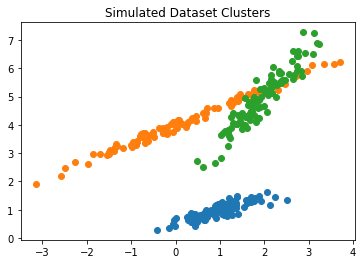

In [267]:
# Means
mean_1 = [1,1]
mean_2 = [0,4]
mean_3 = [2,5]

# Covariances (should be PSD)
cov_1 = np.random.rand(2,2)
cov_1 = np.dot(cov_1, cov_1.transpose())

cov_2 = np.random.rand(2,2)
cov_2 = np.dot(cov_2, cov_2.transpose())

cov_3 = np.random.rand(2,2)
cov_3 = np.dot(cov_3, cov_3.transpose())

# Latent Clusters
x1 = np.random.multivariate_normal(mean = mean_1, cov = cov_1, size = 100)
x2 = np.random.multivariate_normal(mean = mean_2, cov = cov_2, size = 100)
x3 = np.random.multivariate_normal(mean = mean_3, cov = cov_3, size = 100)

# Plots
plt.scatter(x1[:,0], x1[:,1], label = 'Cluster 1')
plt.scatter(x2[:,0], x2[:,1], label = 'Cluster 2')
plt.scatter(x3[:,0], x3[:,1], label = 'Cluster 3')
plt.title('Simulated Dataset Clusters')
plt.show()

### The Mixture Model

We assume some number of clusters, suppose here $k=3$. 

The points are modelled as $ P(x_i | \theta)$, where $x_i$ refers to the $i$-th point in the dataset, and $\theta = \{\mu_1, \mu_2, \mu_3, \Sigma_1, \Sigma_2, \Sigma_3\}$

We introduce a latent variable $t$ which influences which cluster each $x_i$ belongs to, through $P(t_i = c | x_i, \theta)$ 

So, by un-marginalizing $t$, we can write our model as 

$$ P(x_i | \theta) = \sum_{c = 1}^{3} P(x_i | t_i = c, \theta) P(t_i = c|\theta) $$

This means that our $\theta$ now contains additional parameters $\pi_c = P(t_i = c | \theta)$ for each cluster $c$

So, 

$$\theta = \{\pi_1, \pi_2, \pi_3, \mu_1, \mu_2, \mu_3, \Sigma_1, \Sigma_2, \Sigma_3 \}$$


To find optimum $\theta$ for model fitting, let us maximize the likelihood function of $\theta$ given the observed data

$$ \theta = \arg\max_{\theta} P(x_i | \theta)$$

As an initialization step, we take randomly any $\theta$ and hope to improve upon it subsequently

#### $ \textbf{Repeat Till Convergence}$
1. After we have got some (updated) estimate of $\theta$, we compute $P(t_i = c |x_i, \theta)$ for all points $x_i$ 

This can be computed using the Bayes' rule as

$$P(t_i = c |x_i, \theta) = \frac{P(x_i | t_i = c, \theta)P(t_i = c|\theta)}{\sum_{c = 1}^{3}P(x_i | t_i = c, \theta)P(t_i = c|\theta)}$$

where

$$ P(x_i | t_i = c, \theta) \sim N(\mu_c, \Sigma_c)$$

$$ P(t_i = c | \theta) = \pi_c$$


2. Using this, we can solve the maximization problem
$$ \arg\max_{\theta} P(x_i | \theta)$$

which will yield new values of $\theta$ as

$$ \pi_c = \frac{1}{M} \sum_{i = 1}^{M} P(t_i = c | x_i, \theta)$$

$$ \mu_c = \frac{\sum_{i = 1}^{M} P(t_i = c | x_i, \theta)x_i}{\sum_{i = 1}^{M} P(t_i = c | x_i, \theta)}$$

$$ \Sigma_c = \frac{\sum_{i = 1}^{M} P(t_i = c | x_i, \theta)(x_i - \mu_c)(x_i - \mu_c)^T}{\sum_{i = 1}^{M} P(t_i = c | x_i, \theta)}$$


### Code Implementation

In [268]:
# Preparing the Dataset
x = np.vstack([x1, x2, x3])

In [289]:
# Defining Marginal Distributions
def likelihood(i: int, cluster: int, mu: np.array, sigma: np.array):
    return multivariate_normal(mean = mu[cluster], cov = sigma[cluster]).pdf(x[i])

# Defining Priors
def prior(cluster: int, pi: np.array):
    return pi[cluster]

# Calculating Weights for every point belonging in each cluster
def weights(i: int, cluster: int, pi: np.array = pi, mu: np.array = mu, sigma: np.array = sigma):
    numerator = likelihood(i,cluster, mu = mu, sigma = sigma)*prior(cluster, pi = pi)
    denominator = sum([likelihood(i,cluster, mu, sigma)*prior(cluster, pi) for cluster in range(3)])
    return numerator/denominator

In [298]:
# Iteration Parameters
n_iteration = 100

# Initialize the Parameters Randomly
pi_1 = np.random.uniform(low = 0.0, high = 1.0, size = 1)
pi_2 = np.random.uniform(low = 0.0, high = 1.0 - pi_1, size = 1)
pi_3 = 1 - pi_1 - pi_2
pi = [pi_1, pi_2, pi_3]

mu_1 = np.random.uniform(size = 2)
mu_2 = np.random.uniform(size = 2)
mu_3 = np.random.uniform(size = 2)
mu = [mu_1, mu_2, mu_3]

sigma_1 = np.random.rand(2,2)
sigma_1 = np.dot(sigma_1, sigma_1.transpose())
sigma_2 = np.random.rand(2,2)
sigma_2 = np.dot(sigma_2, sigma_2.transpose())
sigma_3 = np.random.rand(2,2)
sigma_3 = np.dot(sigma_3, sigma_3.transpose())
sigma = [sigma_1, sigma_2, sigma_3]

In [300]:
# Bringing it all together

weight_matrix = np.zeros(shape = (x.shape[0],3))

for iteration in range(10):

    mu_history = mu # previous iteration

    # Calculate weights (double for-loops is SLOOOOOW!) | fromfunction did not work
    for row in range(weight_matrix.shape[0]):
        for column in range(weight_matrix.shape[1]):
            weight_matrix[row, column] = weights(i = row, cluster = column, pi = pi, mu = mu, sigma = sigma)

    start = datetime.now()
    # Use weights to update parameters
    for cluster in range(weight_matrix.shape[1]):
        # Pi
        pi[cluster] = np.mean(weight_matrix[:,cluster])
        # Mu
        mu[cluster] = sum([weight_matrix[i,cluster]*x[i] for i in range(x.shape[0])]) / sum(weight_matrix[:,cluster])
        # Sigma
        sigma[cluster] = sum([weight_matrix[i,cluster]*np.outer((x[i] - mu_history[cluster]),(x[i] - mu_history[cluster])) for i in range(x.shape[0])]) / sum(weight_matrix[:,cluster])

    # Logging
    if iteration%2 == 0:
        print('iteration: {}'.format(iteration))

iteration: 0
iteration: 2
iteration: 4
iteration: 6
iteration: 8


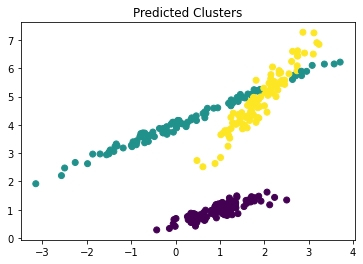

In [301]:
# Final Result Plotting
plt.title('Predicted Clusters')
cluster_assignments = weight_matrix.argmax(axis = 1)
plt.scatter(x[:,0],x[:,1], c = cluster_assignments)
plt.show()